# New calibrator algorithm

This tests out the new calibrator detection algorithm with proper timing and everything.

In [115]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import lusee
import sys, os
from scipy.interpolate import interp1d
sys.path.append('/home/anze/work/lusee/notebooks/calibrator')
os.environ['LUSEE_DRIVE_DIR']='/home/anze/work/lusee/Drive/'
from algorithms import  Comb, Calibrator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


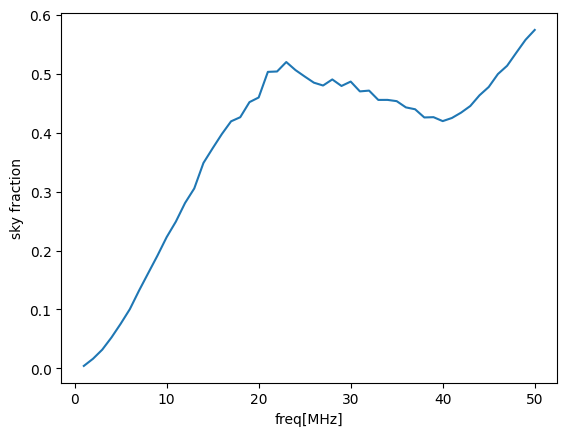

In [116]:
B=lusee.Beam()
plt.plot(B.freq,B.sky_fraction())
plt.xlabel('freq[MHz]')
plt.ylabel('sky fraction')
sky_fraction = interp1d(B.freq,B.sky_fraction(),kind='linear')




Text(0, 0.5, 'sky brightness [W/m^2/Hz/sr]')

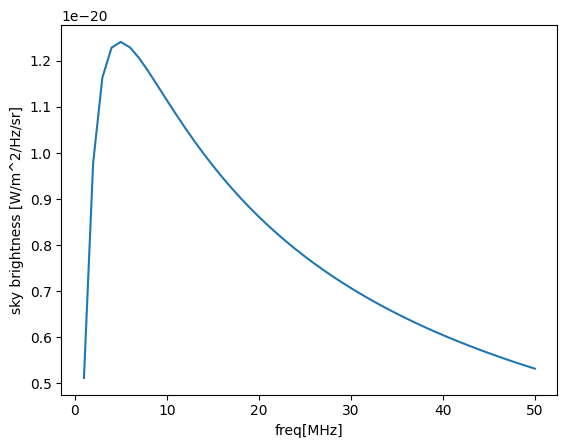

In [117]:
plt.plot(B.freq,lusee.MonoSkyModels.B_NB(B.freq))
plt.xlabel('freq[MHz]')
plt.ylabel('sky brightness [W/m^2/Hz/sr]')

Power per tone 4.999999999999999e-19 W/m^2


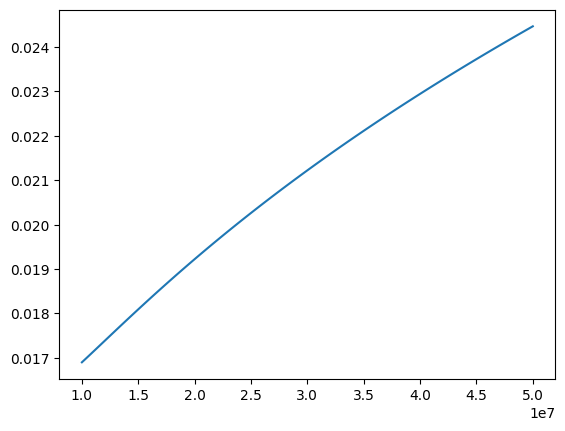

In [158]:
# define signal and sky signals
req_level = 5e-24 * 100e3 ## Appendix A requirement W/m^2 /Hz * 100kHz

print ("Power per tone",req_level,'W/m^2')

def signal_rms(freq):
    freq_MHz = freq/1e6
    sf = sky_fraction(freq_MHz)
    return np.sqrt(req_level*sf)

def noise_rms(freq):
    freq_MHz = freq/1e6
    channel_width = 25e3 ## 25kHz primary channelization
    sf = sky_fraction(freq_MHz)
    sky_area = 2*np.pi
    sky_signal =  lusee.MonoSkyModels.B_NB(freq_MHz)*sf*channel_width*sky_area
    return np.sqrt(sky_signal)

freq=np.linspace(10e6,50e6,100)
plt.plot(freq,signal_rms(freq)/noise_rms(freq))
#plt.plot(freq,noise(freq))

In [159]:
precompensation = np.load('/home/anze/work/lusee/notebooks/calibrator/precompensation.npz')['precomp']
antenna = 1/np.copy(precompensation)
x= np.arange(512)
precompensation_fix = precompensation*(1+60*np.exp(-(x-230)**2/(2*20**2)))
precompensation_fix/=precompensation_fix.sum()


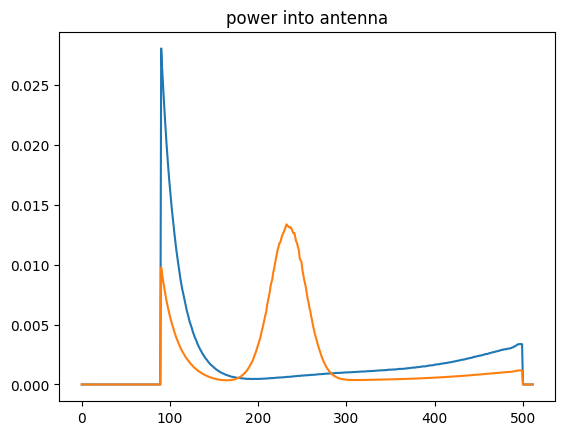

In [160]:
plt.title('power into antenna')
plt.plot(precompensation)
plt.plot(precompensation_fix)

2.3910794939627773


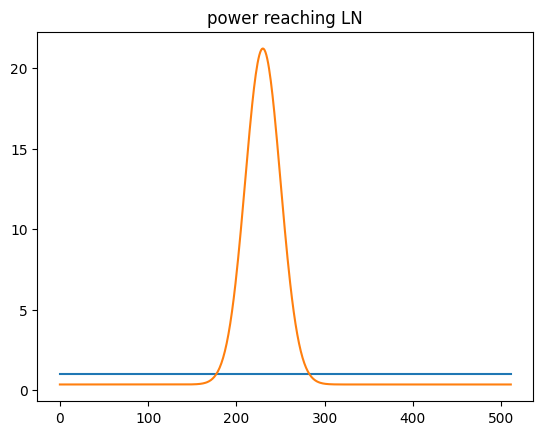

In [161]:
plt.title('power reaching LN')
plt.plot(precompensation*antenna)
plt.plot(precompensation_fix*antenna)
print ((precompensation_fix*antenna).sum()/(precompensation*antenna).sum())

In [162]:
comb=Comb(Nstart= 181, Nend= 983, response=signal_rms, noise=noise_rms, precompensation=precompensation_fix, antenna=antenna)
C = Calibrator(comb, alpha=-0.3,dalpha_dt=0.0, add_noise=True, Nnotch=16, Nintg=64)
#C.produce_data_block()[:,0]
res = C.analyze_data(alpha_start=-0.3,tmax=3,force_detect=True)
res['detect'], res['SNRdBdet']

1.046169660967649e-09 -0.001243732521350771 True
3.1395925815491283e-10 -0.0012250253363246652 True
-1.1776558416941698e-09 -0.001266476846509741 True
-2.1895590177060183e-09 -0.0012516592961900792 True
9.193221805872097e-10 -0.0012391359773878748 True
2.2064787737949815e-09 -0.0011779783269457464 True
-3.1126012750122553e-09 -0.0011736045796398563 True
2.595520194930185e-09 -0.001241886037987746 True
-1.5517457916961605e-09 -0.001250925309304431 True
8.225575562846136e-10 -0.0012223101593505678 True
1.8630202485888478e-09 -0.0012196132162259476 True
3.5102001898231114e-10 -0.0012368393370207312 True
-1.0772439983767182e-09 -0.0012548804358647762 True
1.0388132277559043e-09 -0.0012211872391315788 True
-2.6035092295942178e-09 -0.0012512222400127262 True
-3.647255736137445e-10 -0.0011511236576942732 True
-1.236191797948235e-09 -0.0012093672851429856 True
3.0081337388148563e-09 -0.001157558815831214 True
-1.5413698942610436e-09 -0.0012392913692140942 True
-2.264485807246905e-09 -0.0012336

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 array([13.4499318 , 13.22115719, 13.14338509, 13.1499096 , 13.00398901,
        12.9384018 , 13.40847224, 13.72291511, 13.82272182, 13.25875796,
        13.41799636, 13.37185435, 13.62892597, 13.25175257, 13.48036965,
        13.23552379, 13.27329635, 13.16656786, 13.18410075, 13.44788398,
        13.42916618, 13.44453494, 12.94456539, 13.35383042, 13.44856249,
        13.01363552, 13.22507437, 13.77044619, 13.

rms= 0.004857176823168512


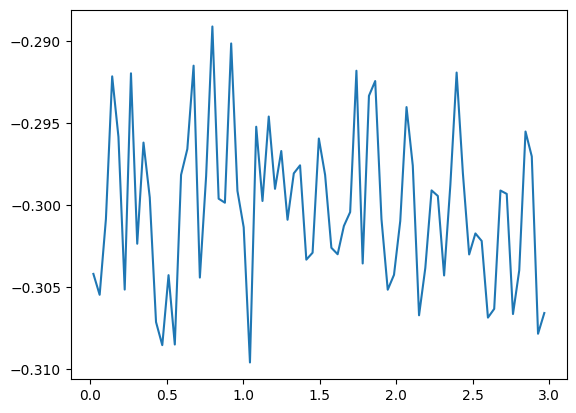

In [163]:
plt.plot(res['t'], res['alphadet'])

print('rms=',res['alphadet'].std())

In [113]:
comb=Comb(Nstart= 181, Nend= 983, response=signal_rms, noise=noise_rms,pilot_idx=[300],pilot_boost=15)
C = Calibrator(comb, alpha=-0.4,dalpha_dt=0.0, add_noise=True, Nnotch=256, Nintg=4)
wb,nb = C.analyze_data_incoherent()

pilot_boost 15
non_pilot_boost 0.6633249580710799


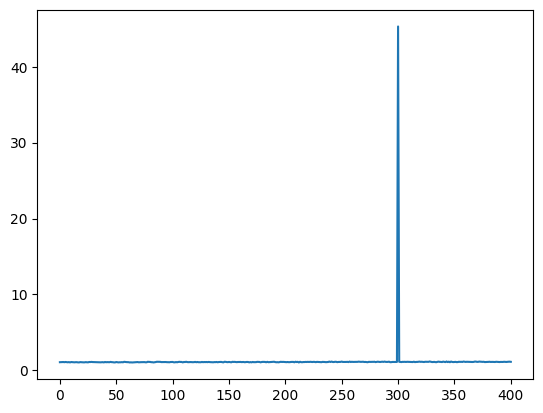

In [114]:
plt.plot(nb/wb)
